Joyce Wang

10/25/2025-10/26/2025

Referring to `Python_exploring_h5ad_files.ipynb` and the [Scanpy Preprocessing and clustering tutorial](https://scanpy.readthedocs.io/en/stable/tutorials/basics/clustering.html#nearest-neighbor-graph-construction-and-visualization).

**This notebook includes:**
- Reading in h5ad files in our dataset
- Figuring out variable names in our adata and seeing if using ad.concat() + adding a `sample` column, vs. using sc.concat(), affects things downstream
- Exploring adata
- Examining the cell labels in the cell metadata (adata.obs['AIFI_L2']) to see if any labels are underrepresented in any of the drug treatments
     - Visualizing with bar charts and heatmaps
-  Scanpy preprocessing, dimensionality reduction (PCA, UMAPs) and clustering

In [1]:
# Core libraries
import hisepy
import numpy as np
import scanpy as sc
import anndata as ad
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

/home/workspace/environment/pythonscrna12/lib/python3.13/site-packages/leidenalg/VertexPartition.py:413: SyntaxWarning: invalid escape sequence '\m'
  .. math:: Q = \\frac{1}{m} \\sum_{ij} \\left(A_{ij} - \\frac{k_i^\mathrm{out} k_j^\mathrm{in}}{m} \\right)\\delta(\\sigma_i, \\sigma_j),
/home/workspace/environment/pythonscrna12/lib/python3.13/site-packages/leidenalg/VertexPartition.py:788: SyntaxWarning: invalid escape sequence '\m'
  .. math:: Q = \\sum_{ij} \\left(A_{ij} - \\gamma \\frac{k_i^\mathrm{out} k_j^\mathrm{in}}{m} \\right)\\delta(\\sigma_i, \\sigma_j),
/home/workspace/environment/pythonscrna12/lib/python3.13/site-packages/leidenalg/Optimiser.py:27: SyntaxWarning: invalid escape sequence '\g'
  implementation therefore does not guarantee subpartition :math:`\gamma`-density.
/home/workspace/environment/pythonscrna12/lib/python3.13/site-packages/leidenalg/Optimiser.py:346: SyntaxWarning: invalid escape sequence '\s'
  .. math:: Q = \sum_k \\lambda_k Q_k.


# Read in .h5ad files in our File Set

In [2]:
h5ad_files = hisepy.cache_fileset('f48bf688-1a5f-456c-b0b0-c6ec870ec003')

In [3]:
# view the first five file names
h5ad_files[0:5]

['/home/workspace/input/1742749117/fileset/f48bf688-1a5f-456c-b0b0-c6ec870ec003/rhodium-niobium-silver/Afatinib_BIBW2992_counts_filtered_labeled_sampled.h5ad',
 '/home/workspace/input/1742749117/fileset/f48bf688-1a5f-456c-b0b0-c6ec870ec003/rhodium-niobium-silver/Afatinib_dimaleate_counts_filtered_labeled_sampled.h5ad',
 '/home/workspace/input/1742749117/fileset/f48bf688-1a5f-456c-b0b0-c6ec870ec003/rhodium-niobium-silver/Baricitinib_LY3009104_INCB028050_counts_filtered_labeled_sampled.h5ad',
 '/home/workspace/input/1742749117/fileset/f48bf688-1a5f-456c-b0b0-c6ec870ec003/rhodium-niobium-silver/Baricitinib_phosphate_counts_filtered_labeled_sampled.h5ad',
 '/home/workspace/input/1742749117/fileset/f48bf688-1a5f-456c-b0b0-c6ec870ec003/rhodium-niobium-silver/Canertinib_CI-1033_counts_filtered_labeled_sampled.h5ad']

In [4]:
# initialize a list
adata_list = []

# iterate over the list h5ad_files to use Scanpy to read the file
for h5ad_file in h5ad_files:
    adata = sc.read_h5ad(h5ad_file)
    # append anndata file object into the list
    adata_list.append(adata)

In [5]:
# view the first item of the list
adata_list[0]

AnnData object with n_obs × n_vars = 25000 × 1916
    obs: 'original_barcodes', 'batch_id', 'pool_id', 'chip_id', 'well_id', 'n_umis', 'n_genes', 'plate_location', 'cyto_treatment', 'drug_treatment', 'drug_name', 'drug_cas_number', 'drug_mw', 'drug_solvent', 'drug_pathway', 'drug_target', 'drug_description', 'drug_chembl_name', 'drug_chembl_id', 'AIFI_L1', 'AIFI_L2', 'leiden_2'
    uns: 'drug_name_colors', 'leiden_2', 'neighbors', 'pca', 'umap'
    obsm: 'X_pca', 'X_umap'
    obsp: 'connectivities', 'distances'

## ad.concat() vs. sc.concat(), and meaning/use of a `sample` column:

**QUESTION: Does using this chunk of code with `ad.concat` from the Scanpy tutorial change how adata looks compared to if I used `sc.concat` from `Python_exploring_h5ad_files.ipynb`?**
- I'm guessing if I use that code chunk with `ad.concat` from the Scanpy tutorial, I'm labelling a "sample" column and making sure I'm getting unique observation names (cell IDs).
- This could affect the dimensionality reduction and clustering part of this notebook (and downstream).
- NOTE: I'm pretty sure this `sample` column is the same thing as the `drug_name` column, as there are 18 samples (18 drug names).
- Because `sample` is basically `drug_name`, I can also use `sc.concat` like from the Jupyter Notebook-- and just replace any instance where I see `sample` being graphed with `drug_name` during dimensionality reduction and clustering.
- Basically: following either the Scanpy tutorial or Jupyer notebook tutorial here for concatenation will work. If I follow the Scanpy tutorial, the new `sample` column is essentially the `drug_name`.

In [6]:
# using anndata to concatenate: code chunk from Scanpy tutorial

# combine multiple anndata objects and adds a "sample" column telling you which dataset each cell came from; aka, which DRUG NAME each cell was treated with!
adata = ad.concat(adata_list, label="sample")

# make sure all observations are unique
adata.obs_names_make_unique()

# filtering out CD8aa because there aren't enough
adata = adata[adata.obs.AIFI_L2 != "CD8aa"]

/home/workspace/environment/pythonscrna12/lib/python3.13/site-packages/anndata/_core/merge.py:1667: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  concat_annot = pd.concat(


## Normalization

In [7]:
# help(adata)
adata.layers["counts"] = adata.X.copy()

# Normalizing to median total counts
sc.pp.normalize_total(adata, target_sum = 1e4)


adata.layers["log_transformed"] = np.log1p(adata.X)
# Logarithmize the data
sc.pp.log1p(adata)
# sc.pp.scale(adata)

/tmp/ipykernel_1182/2378854993.py:2: ImplicitModificationWarning: Setting element `.layers['counts']` of view, initializing view as actual.
  adata.layers["counts"] = adata.X.copy()


## Trying out DEG
Seems we may need to filter our genes first (didn't fix it)

was getting log2 scanpy/numpy errors... those went away after commenting out scale() earlier, but now we have divide by zero errors when using the wilcoxon method.

In [14]:
# making a dictionary of subsetted data where the key is the cell type and the value is the anndata object
subsets_cells = {}

for cell_type in adata.obs['AIFI_L2'].unique():
    # print(f'current cell type is {cell_type}')
    cell_type_subset = adata[adata.obs.AIFI_L2 == cell_type].copy()
    sc.tl.rank_genes_groups(
        adata = cell_type_subset,
        groupby = "drug_name",
        reference = "DMSO Control",
        method = "wilcoxon",
        layer = "log_transformed"
    )
    subsets_cells[cell_type] = cell_type_subset

# print(subsets_cells)

# figure out grabbing the data frames from these -- adata.to_df()

# get_rank

CD4 Central Memory
categories: Afatinib (BIBW2992), Afatinib dimaleate, Baricitinib (LY3009104, INCB028050), etc.
var_group_labels: Afatinib (BIBW2992), Afatinib dimaleate, Baricitinib (LY3009104, INCB028050), etc.


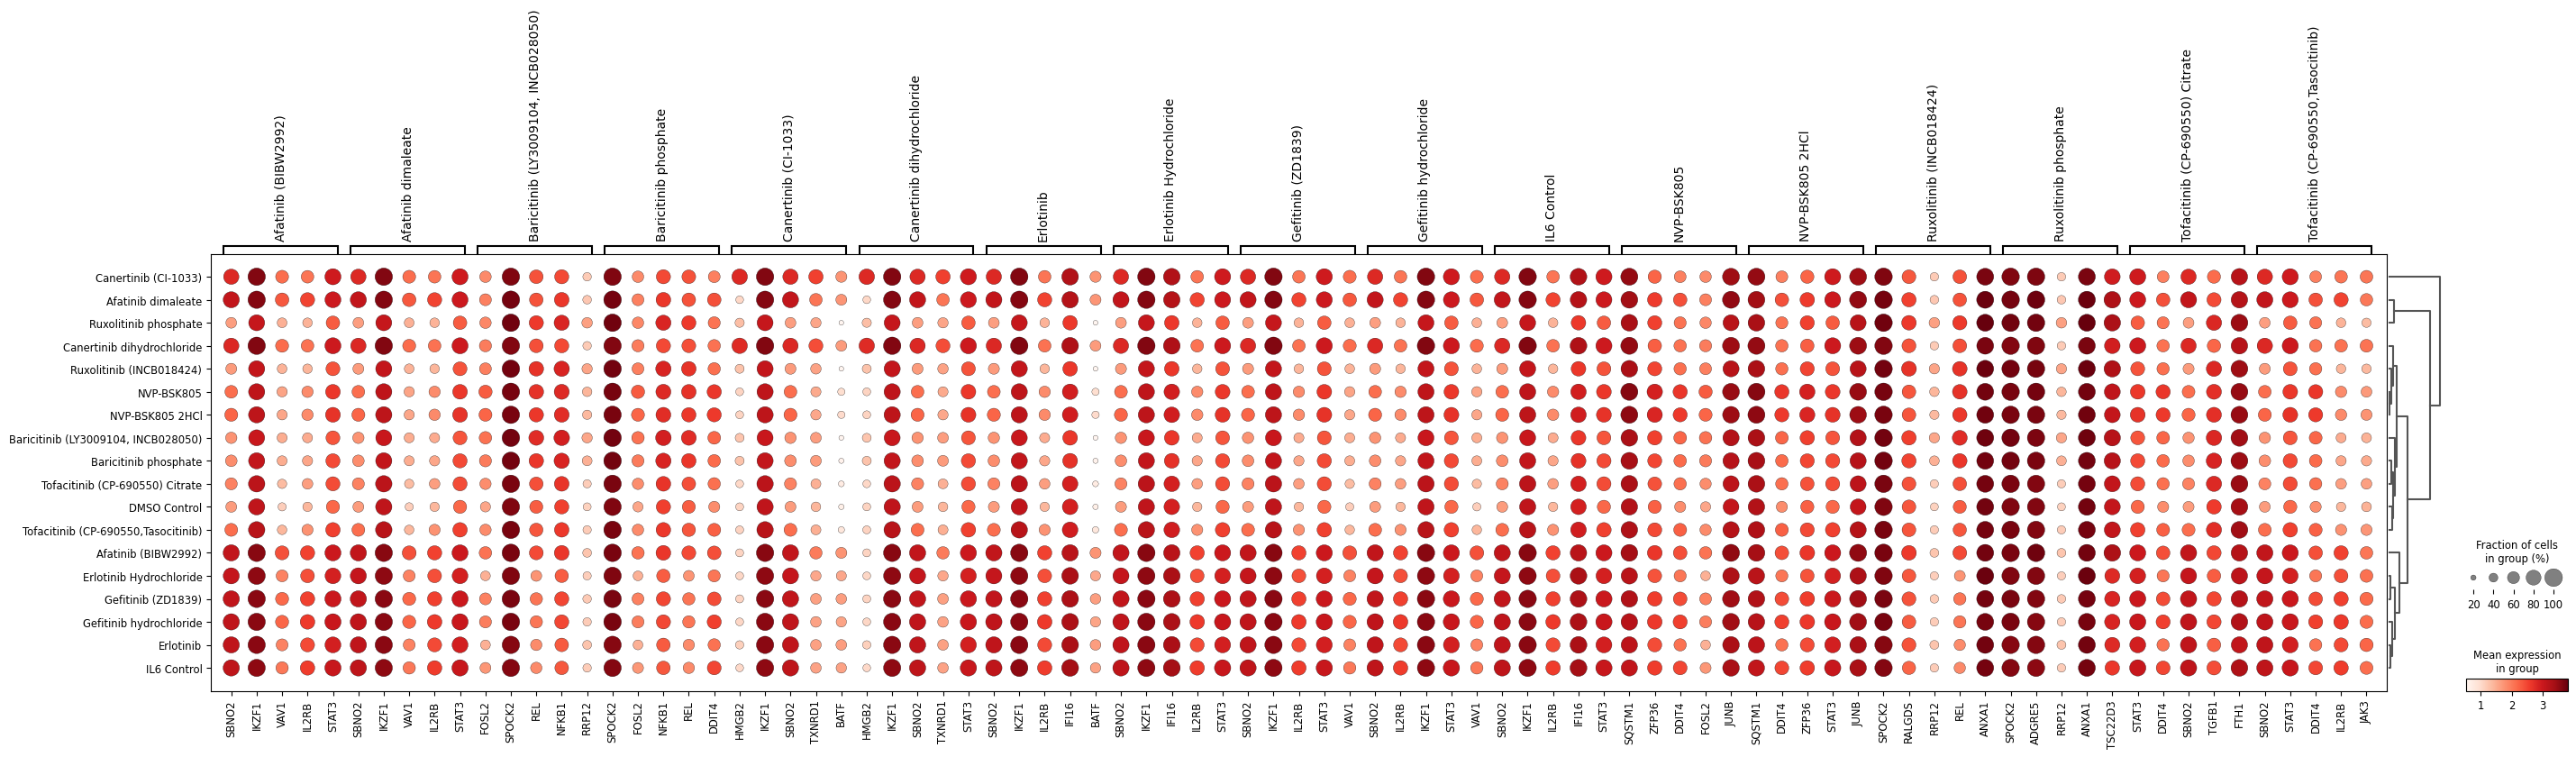

CD8 Naive
categories: Afatinib (BIBW2992), Afatinib dimaleate, Baricitinib (LY3009104, INCB028050), etc.
var_group_labels: Afatinib (BIBW2992), Afatinib dimaleate, Baricitinib (LY3009104, INCB028050), etc.


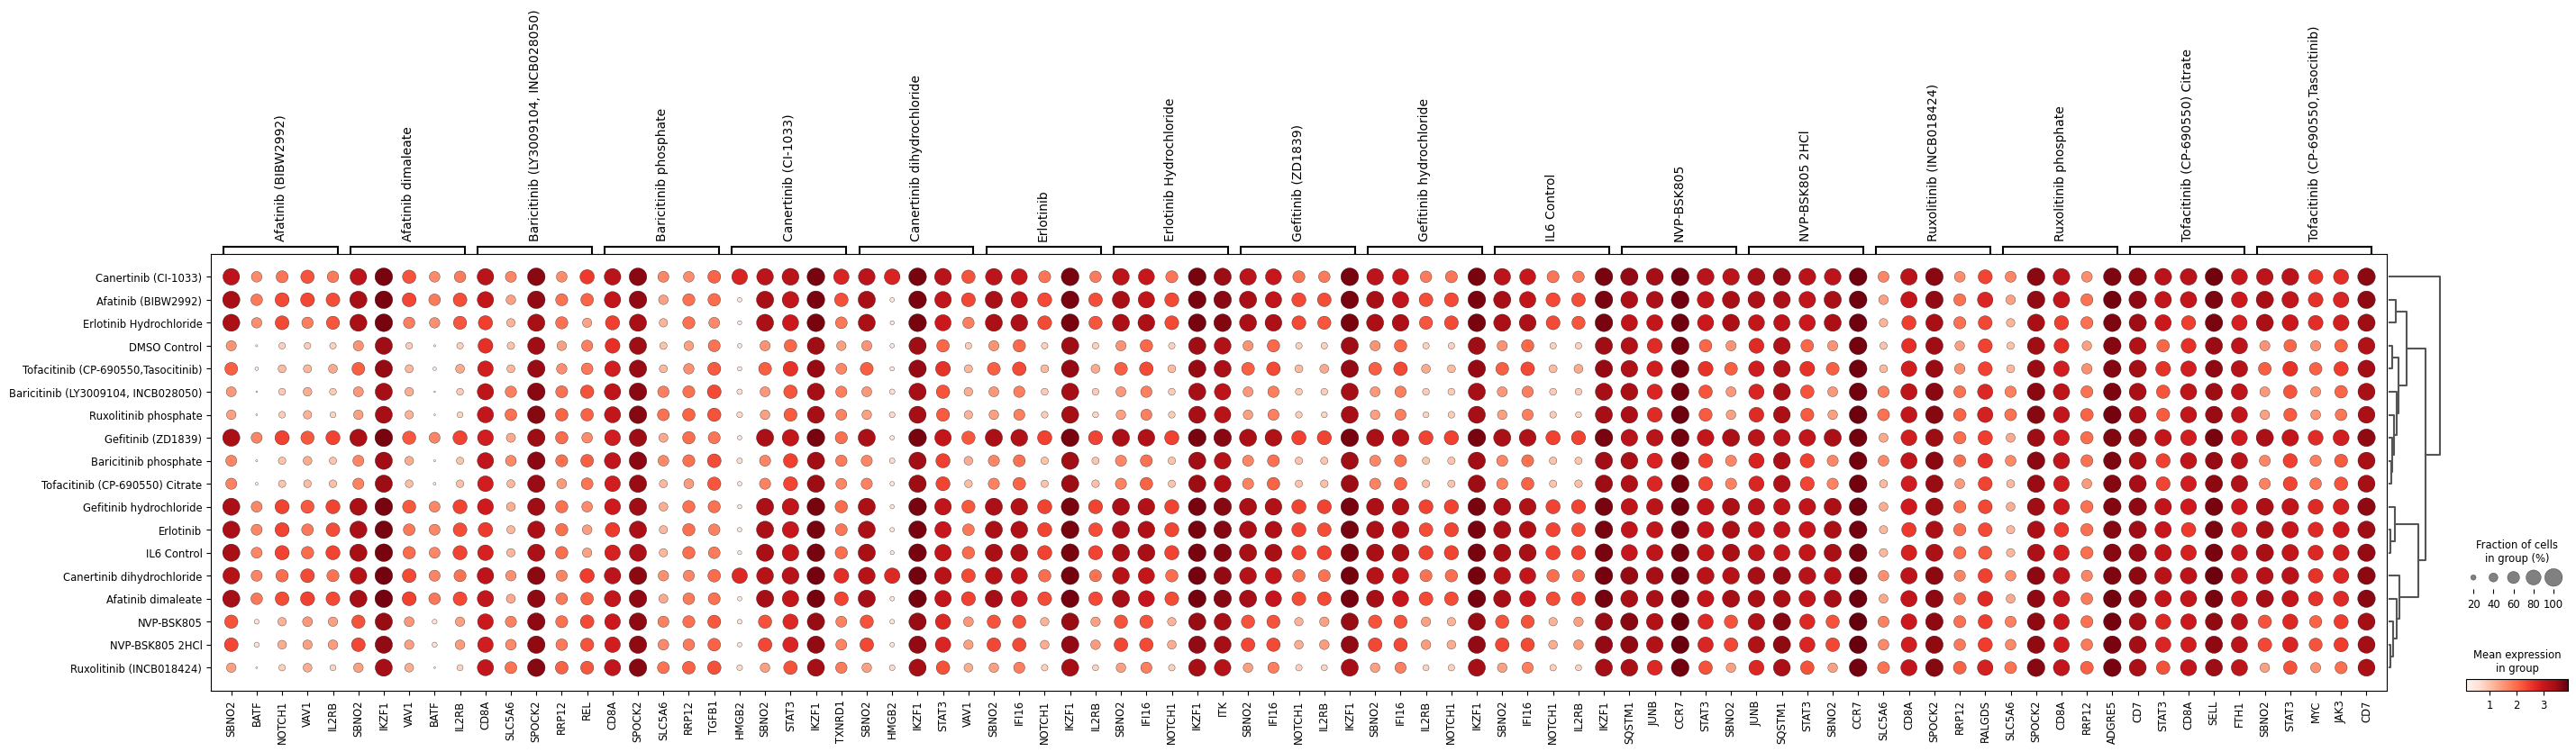

CD8 Effector Memory
categories: Afatinib (BIBW2992), Afatinib dimaleate, Baricitinib (LY3009104, INCB028050), etc.
var_group_labels: Afatinib (BIBW2992), Afatinib dimaleate, Baricitinib (LY3009104, INCB028050), etc.


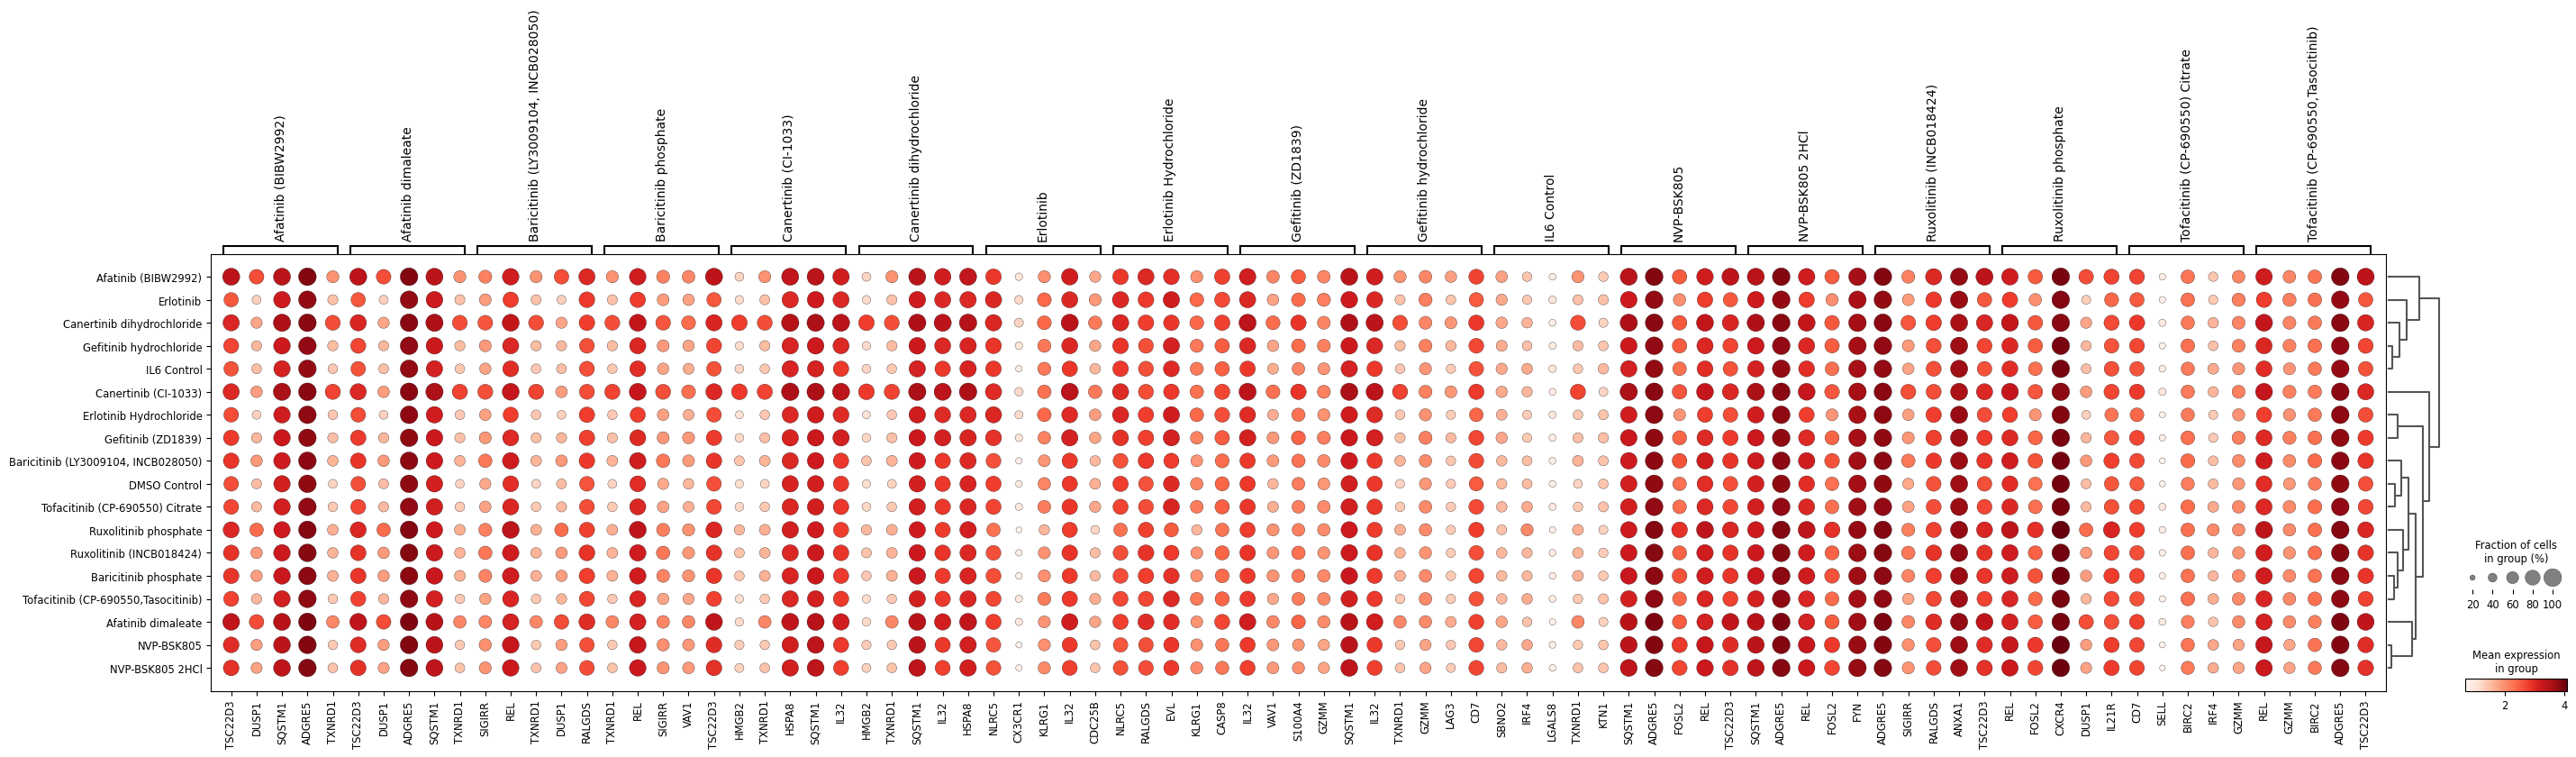

CD8 Central Memory
categories: Afatinib (BIBW2992), Afatinib dimaleate, Baricitinib (LY3009104, INCB028050), etc.
var_group_labels: Afatinib (BIBW2992), Afatinib dimaleate, Baricitinib (LY3009104, INCB028050), etc.


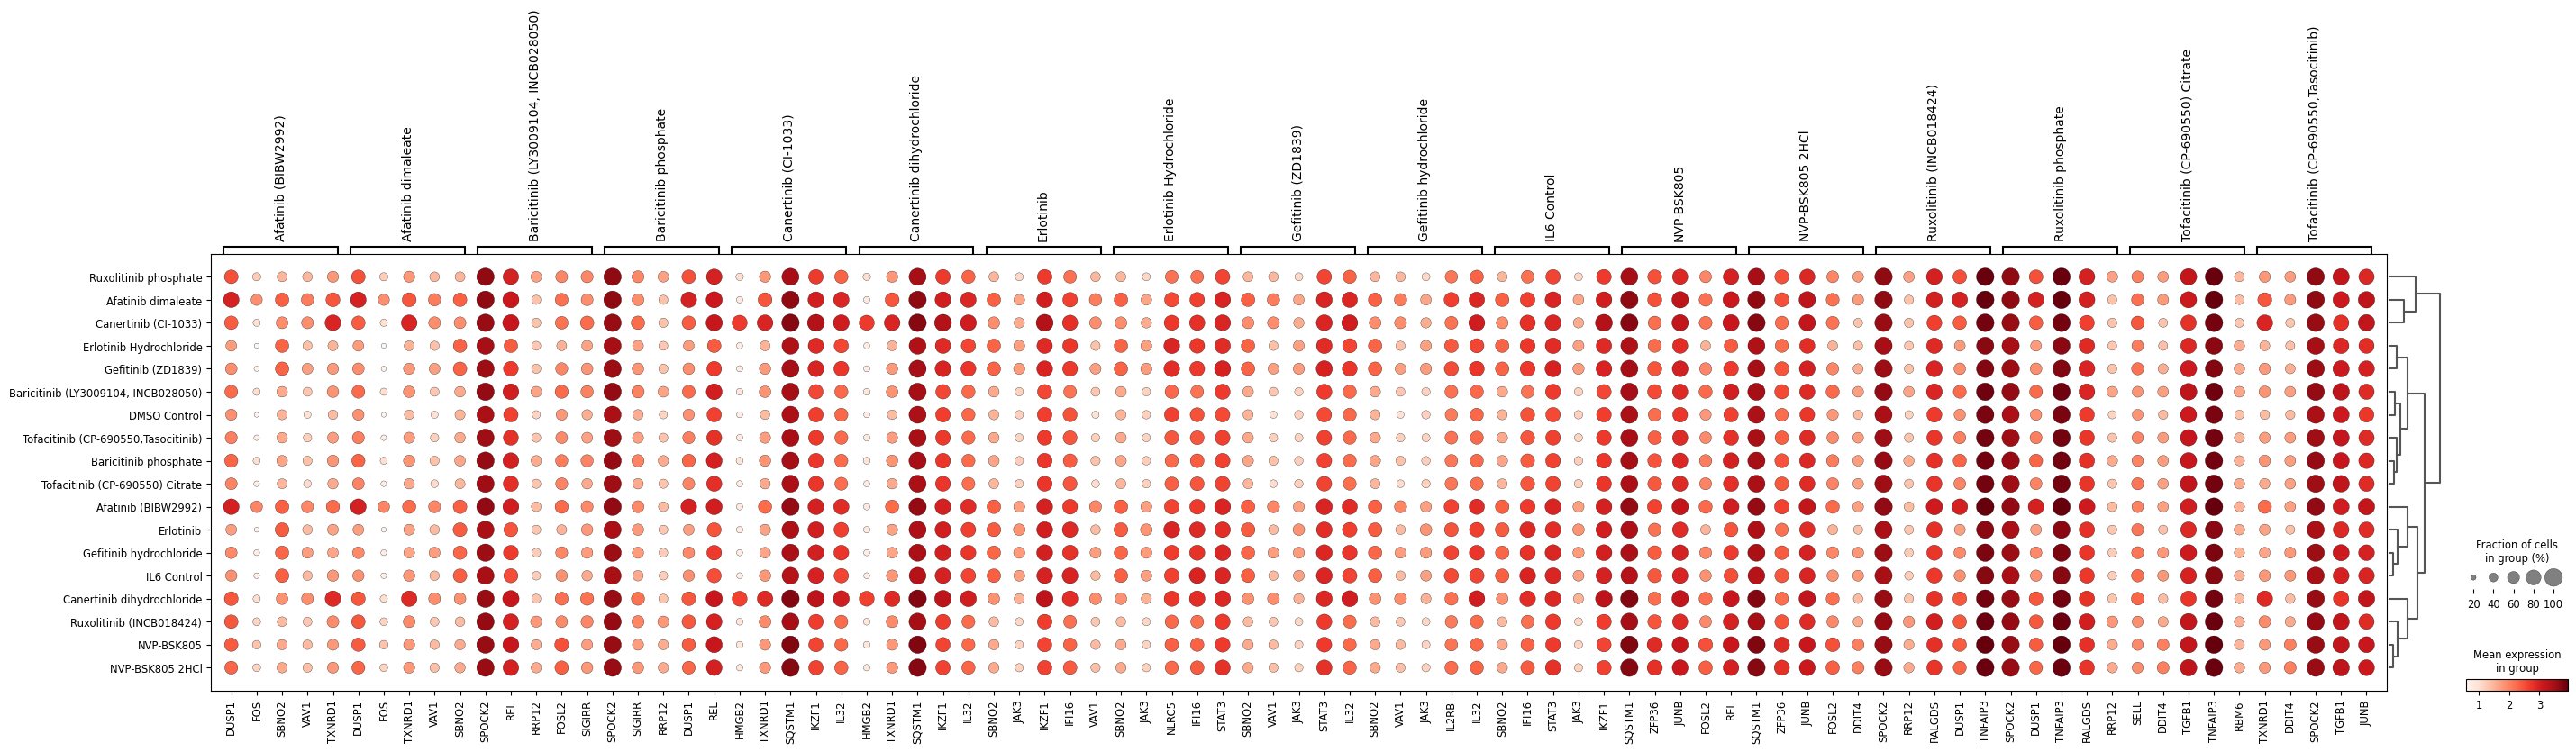

CD4 Naive
categories: Afatinib (BIBW2992), Afatinib dimaleate, Baricitinib (LY3009104, INCB028050), etc.
var_group_labels: Afatinib (BIBW2992), Afatinib dimaleate, Baricitinib (LY3009104, INCB028050), etc.


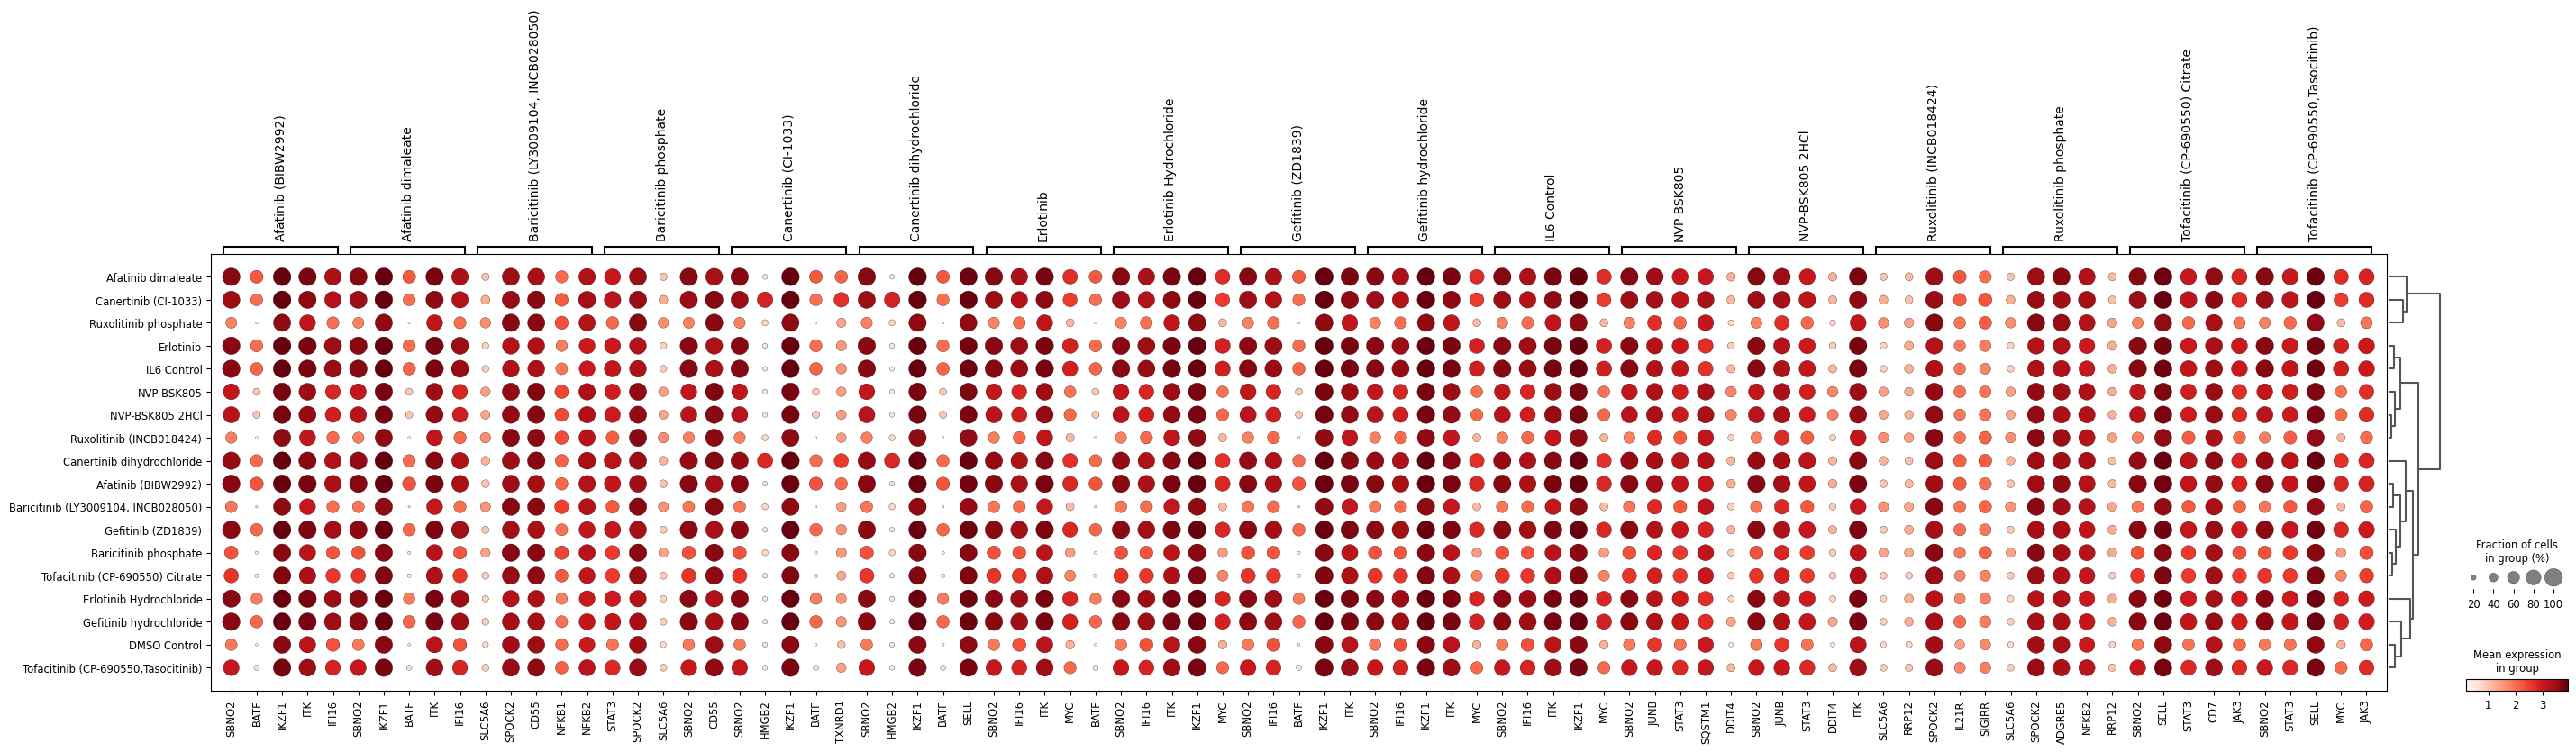

CD4 Effector Memory
categories: Afatinib (BIBW2992), Afatinib dimaleate, Baricitinib (LY3009104, INCB028050), etc.
var_group_labels: Afatinib (BIBW2992), Afatinib dimaleate, Baricitinib (LY3009104, INCB028050), etc.


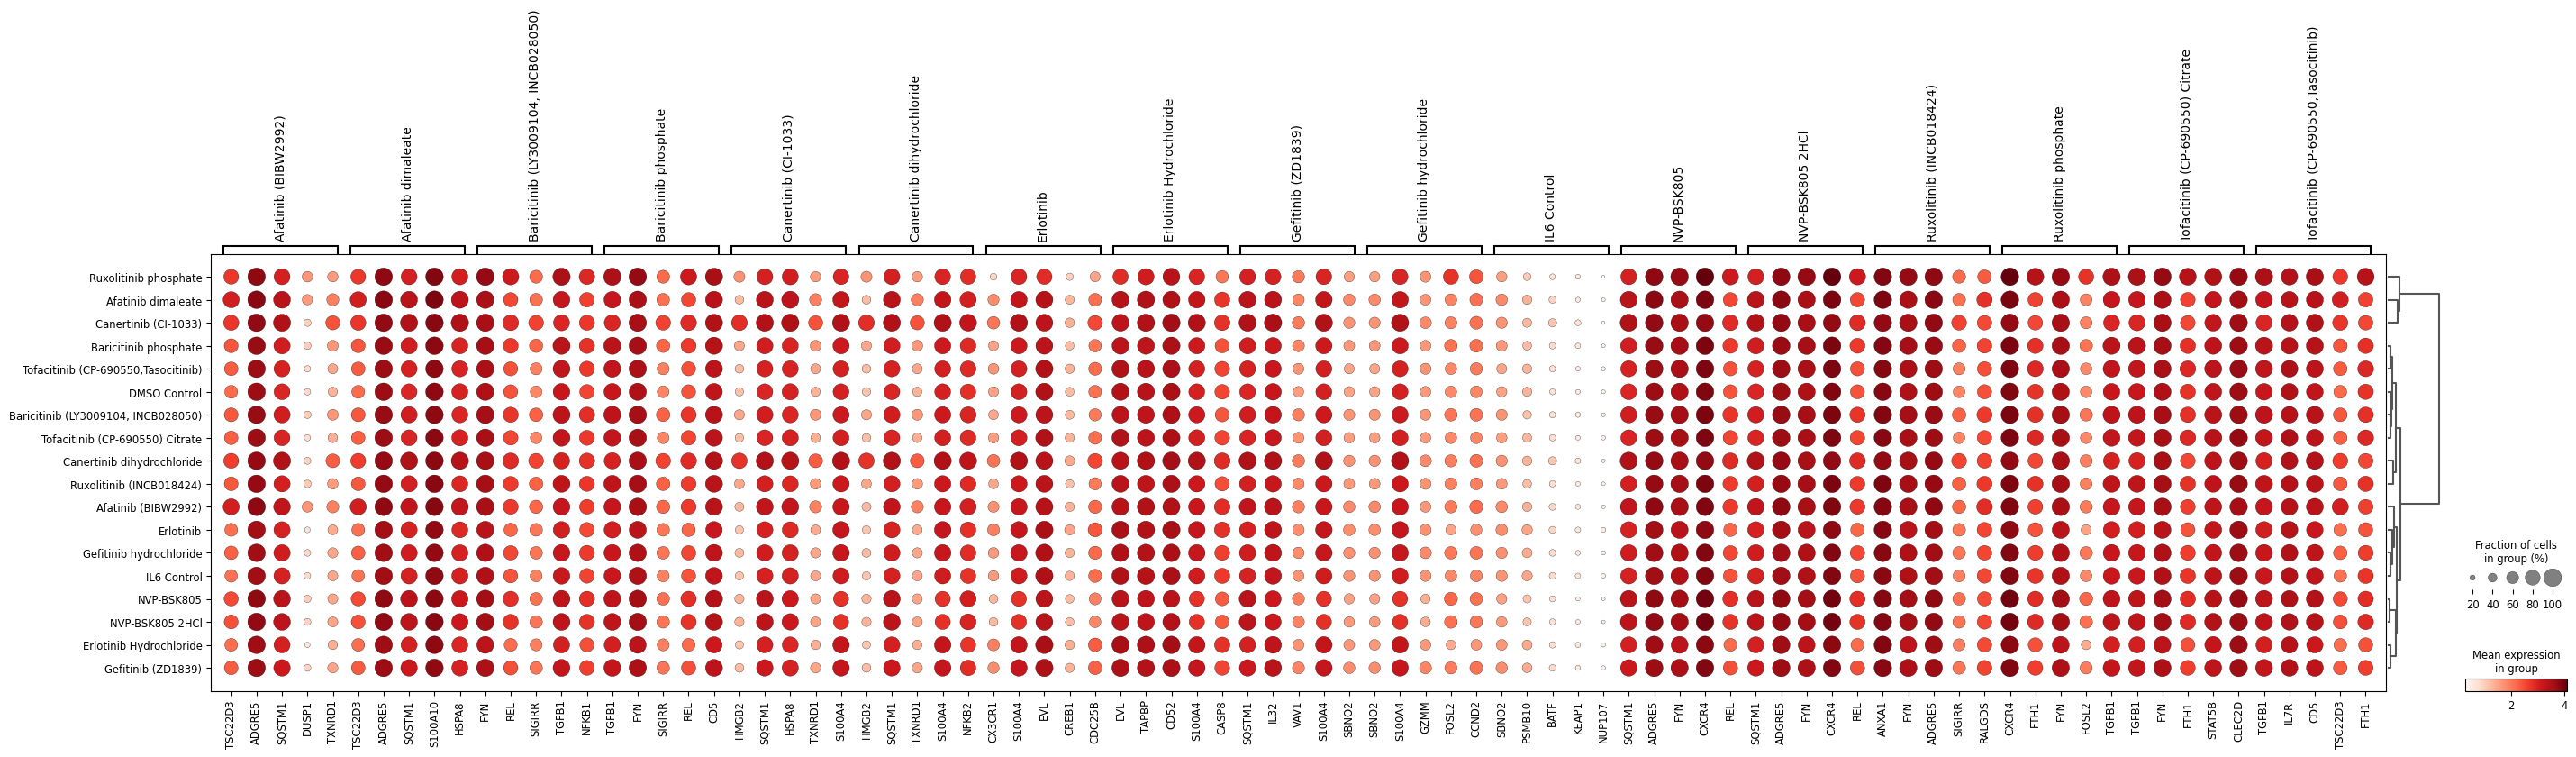

MAIT
categories: Afatinib (BIBW2992), Afatinib dimaleate, Baricitinib (LY3009104, INCB028050), etc.
var_group_labels: Afatinib (BIBW2992), Afatinib dimaleate, Baricitinib (LY3009104, INCB028050), etc.


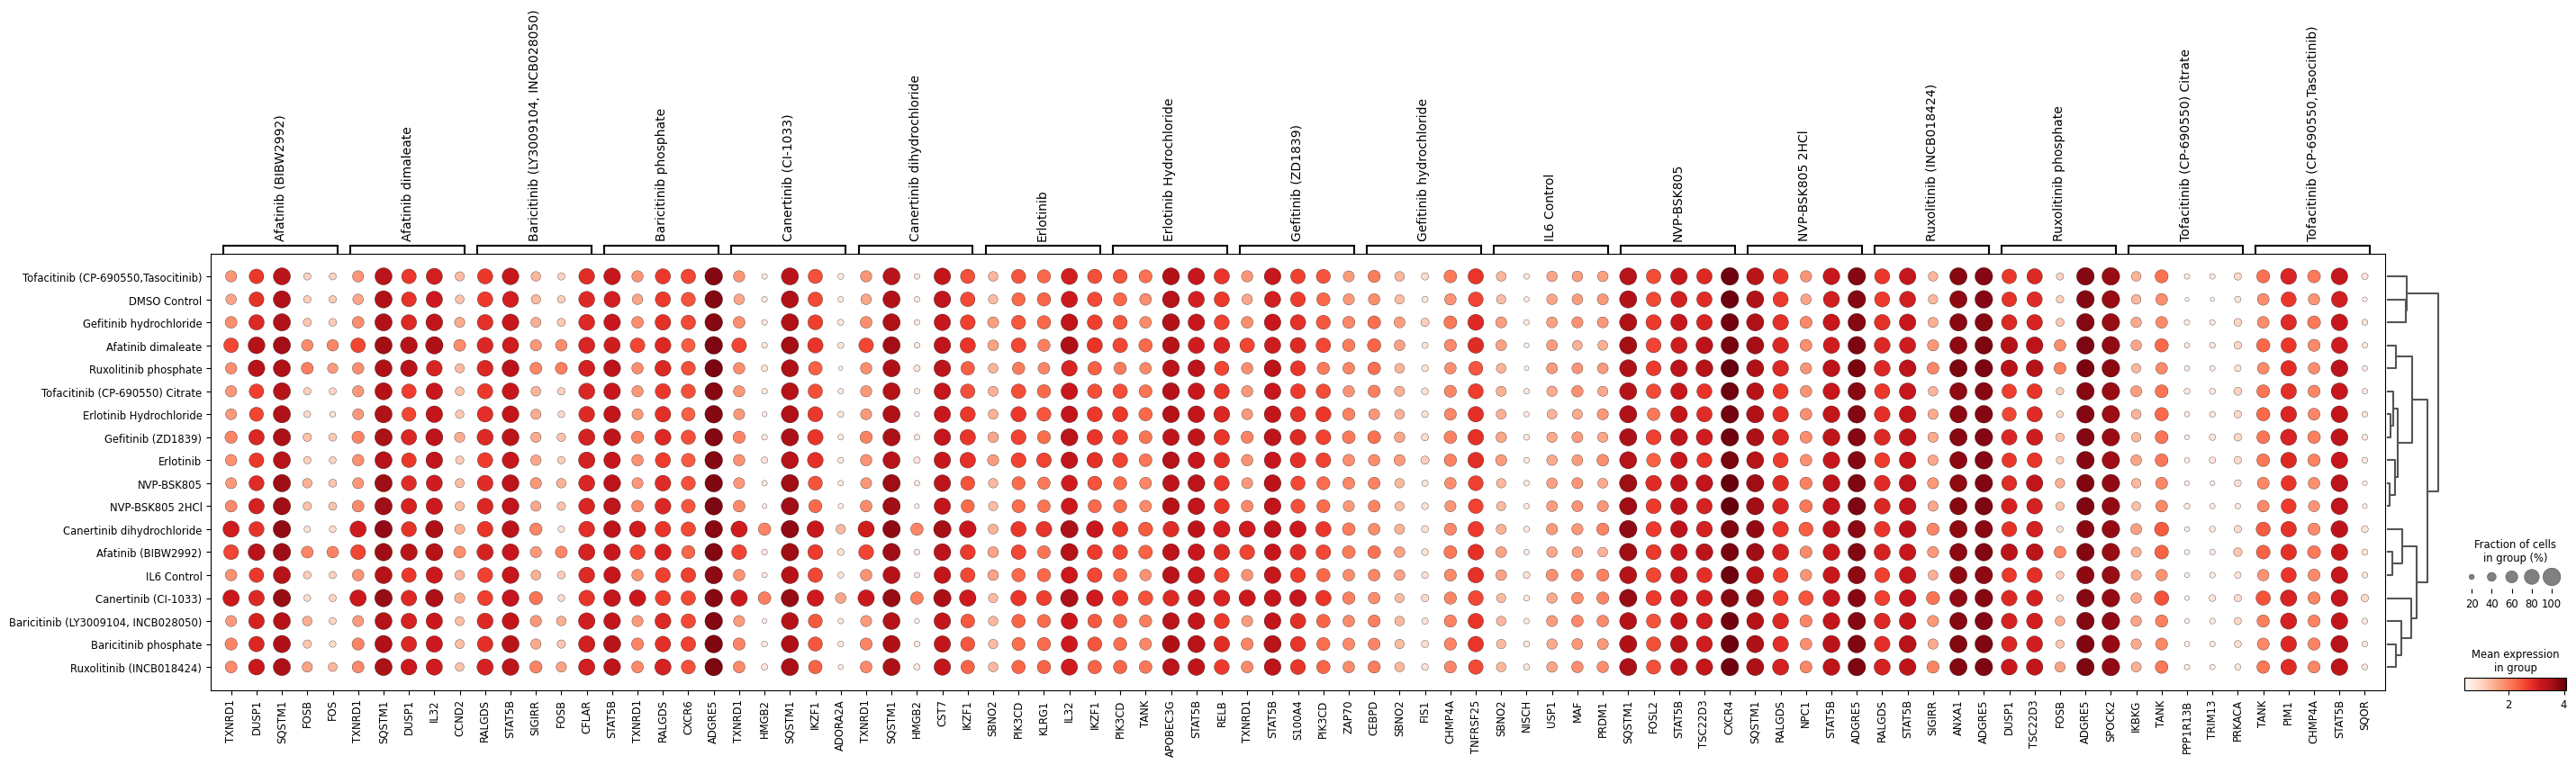

Treg
categories: Afatinib (BIBW2992), Afatinib dimaleate, Baricitinib (LY3009104, INCB028050), etc.
var_group_labels: Afatinib (BIBW2992), Afatinib dimaleate, Baricitinib (LY3009104, INCB028050), etc.


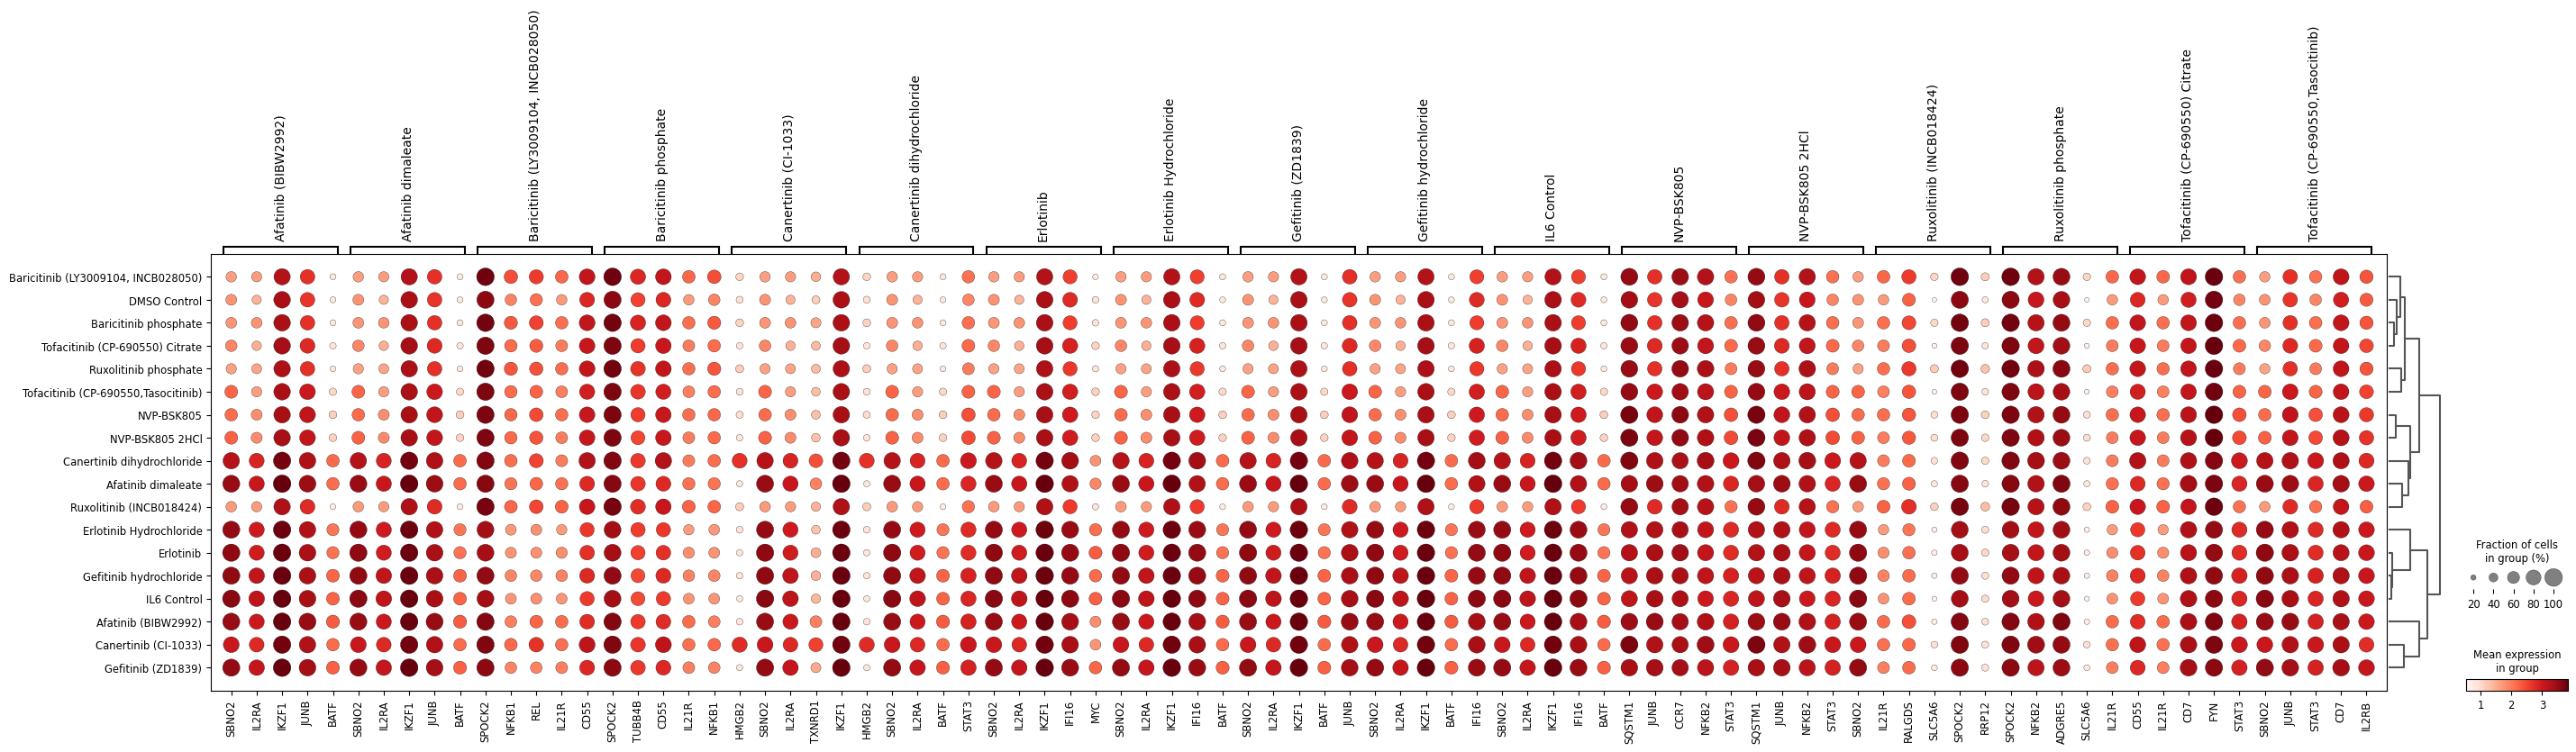

In [18]:
for cell_type, subset_cell in subsets_cells.items():    
    print(cell_type)
    sc.pl.rank_genes_groups_dotplot(subset_cell, groupby="drug_name", n_genes=5)

Check scanpy preprocessing filter genes -- dropped in the slack
- min cells (>0)
- min counts